In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

import sys
sys.path.append('..')
import utils.word_transition_network as wtn_module
from utils.rover import RoverVotingScheme
from utils.word_transition_network import *

from collections import Counter
import collections

from irover_application.extract_features import Processor

In [3]:
import yt.wrapper as yt
yt.config.set_proxy("hahn")

In [4]:
data_table = yt.read_table(
    "//home/voice/edvls/tickets/VA-442_ideal_testsets/quasar-general_with_spotter_ideal_annotations_2019-04-18__2019-04-24"
)
data_table = list(data_table)
data_table[0].keys()

dict_keys(['mds_key', 'linguists_sugested_text', 'toloka_text', 'toloka_assignments_repeat_2_with_chorus_and_pitch', 'spotter_tail_trim', 'toloka_assignments_repeat_4_selected_workers_with_pitch', '_other', 'check_in_yang_results', 'spotter_mds_key', 'date', 'number_of_speakers', 'text', 'downloadUrl', 'toloka_assignments_repeat_3_selected_workers_with_chorus_and_pitch', 'spotter_max_length', 'raw_text_linguists', 'linguists_comment', 'toloka_number_of_speakers', 'mdsFileName', 'toloka_assignments_repeat_1', 'speech', 'linguists_worker_id', 'toloka_speech', 'mark', 'url_in_first_toloka', 'asr_mds_key', 'toloka_assignments', 'audio', 'url', 'initialFileName'])

In [6]:
AggregationResult = collections.namedtuple('AggregationResult', 'text confidence cost')

In [7]:
Context = collections.namedtuple('Context', 'max_num_answers for_fitting platform')
context = Context(10, True, 'toloka')
context

Context(max_num_answers=10, for_fitting=True, platform='toloka')

In [9]:
def convert_to_array(features):
    X = list()
    Y = list()
    for task_id, item0 in features.items():
        for cost, item1 in item0.items():
            for position, item2 in item1.items():
                for word, item3 in item2.items():
                    x, y = item3
                    X.append(np.array(x))
                    Y.append(1 if y else -1)
    return np.array(X), np.array(Y)

In [10]:
def aggregate_prod(raw_data):
    """
       aggregation from prod
    """
    cost = 2
    while cost < 5:
        cost += 1
        answers = [(x["text"], x["speech"]) for x in raw_data[:cost]]
        answers = Counter(answers)
        if answers.most_common(1)[0][1] >= 3:
            break

    texts = Counter()
    speechs = Counter()
    for text, speech in [(x["text"], x["speech"]) for x in raw_data[:cost]]:
        if speech != "BAD" and text:
            text = text.lower().replace('ё', 'е')
        else:
            text = ""
        speechs.update([speech])
        texts.update([text])
    
    
    text, text_rate = max(texts.items(), key=lambda x: (x[1], x[0] != ""))
    if text != "" and text_rate >= 2:
        conf = text_rate * 1.0 / sum(texts.values())
    else:
        text = None
        conf = 0
    common = speechs.most_common(2)
    speech, speech_rate = common[0]
    if speech == "BAD" and len(common) >= 2 and common[1][1] == speech_rate:
        speech = common[1][0]

    # conf = text_rate / sum(texts.values())
    return AggregationResult(text, conf, cost)

In [11]:
def evaluate_metrics(data, field, algorithm, treshhold=0, cluster_refernces=None, print_=True):
    errors = 0
    total_length = 0
    aggregated = 0
    total_items = 0
    correct = 0
    cost = 0
    for row in data:
        if row["mark"] != "TEST":
            continue
        total_items += 1
        hyp = algorithm(sorted(row[field], key=lambda x: x["submit_ts"]))
        cost += hyp.cost
        if (hyp.text is None) or (hyp.confidence < treshhold):
            continue
        hyp = hyp.text
        aggregated += 1
        _, e, l = calculate_wer(row["text"], hyp, cluster_refernces)
        errors += e
        if e == 0:
            correct += 1
        total_length += l

    accuracy = correct / aggregated
    wer = errors / total_length
    aggregated_part = aggregated / total_items
    cost = cost / total_items
    if print_:
        print("Aggregated: {:.4%}\nWER: {:.4%}\nAccuracy: {:.4%}\nMean overlap: {:.4}".format(
            aggregated_part, wer, accuracy, cost
        ))
    return aggregated_part, wer, accuracy, cost

In [13]:
valid_table = yt.read_table(
    "//home/voice/edvls/tickets/VA-442_ideal_testsets/quasar-general_with_spotter_ideal_annotations_2019-04-18__2019-04-24"
)
valid_table = list(valid_table)

In [14]:
valid_rows = [row for row in valid_table if row["mark"] == "TEST"]

In [15]:
def preaggregate_with_clf(features, clf):
    matching = dict()
    X = list()
    for task_id, item0 in features.items():
        task_id = '/'.join(task_id.split('/')[-2:])
        for cost, item1 in item0.items():
            for position, item2 in item1.items():
                for word, item3 in item2.items():
                    x, y = item3
                    X.append(np.array(x))
                    matching[(task_id, cost, position, word)] = len(X) - 1
    probabilites = clf.predict_proba(X)[:, 1]
    results = dict()
    for task_id, item0 in features.items():
        task_id = '/'.join(task_id.split('/')[-2:])
        results[task_id] = dict()
        for cost, item1 in sorted(item0.items()):
            results[task_id][cost] = list()
            for position, item2 in sorted(item1.items()):
                words = list(item2.keys())
                probs = np.array([probabilites[matching[(task_id, cost, position, word)]] for word in words])
                pos = np.argmax(probs)
                score = probs[pos]
                word = words[pos]
                results[task_id][cost].append((word, score))
    return results

In [37]:
def evaluate_metrics_from_dict(data, aggregation_results, treshhold=0, max_cost=10, cluster_refernces=None, print_=True, add_threshold=0.0):
    errors = 0
    total_length = 0
    aggregated = 0
    total_items = 0
    correct = 0
    cost = 0
    for row in data:
        if row["mark"] != "TEST":
            continue
        total_items += 1
        hyp = aggregation_results['/'.join(row['url'].split('/')[-2:])]
        cost += hyp.cost
        if (hyp.text is None) or (hyp.cost != max_cost and hyp.confidence < treshhold + add_threshold) or hyp.confidence < treshhold:
            continue
        hyp = hyp.text
        aggregated += 1
        _, e, l = calculate_wer(row["text"], hyp, cluster_refernces)
        errors += e
        if e == 0:
            correct += 1
        total_length += l

    accuracy = correct / aggregated
    wer = errors / total_length
    aggregated_part = aggregated / total_items
    cost = cost / total_items
    if print_:
        print("Aggregated: {:.4%}\nWER: {:.4%}\nAccuracy: {:.4%}\nMean overlap: {:.4}".format(
            aggregated_part, wer, accuracy, cost
        ))
    return aggregated_part, wer, accuracy, cost

In [17]:
def aggregate_rover_with_clf_(rows, features, field_name, clf, treshhold=0.51, min_cost=3, max_cost=10, cluster_references=None):
    """
       aggregation from prod
    """
    clf_results = preaggregate_with_clf(features, clf)
    results = dict()
    for task_id, item0 in clf_results.items():
        for cost, item1 in sorted(item0.items()):
            if cost < min_cost or cost > max_cost: 
                continue
            text = " ".join(value for value, score in item1 if value != "")
            score = sum(score for value, score in item1) / len(item1)
            if score >= treshhold or cost == max_cost: #MAX_NUM_ANSWERS:
                if text == "":
                    conf = 0
                    text = None
                elif score < treshhold:
                    conf = 0
                    text = None
                else:
                    conf = score
                results[task_id] = AggregationResult(text, conf, cost)
                break
    return results

In [18]:
def evaluate_metrics_clf_(data, 
                          features, 
                          field_name, 
                          clf, 
                          treshhold=0.51, 
                          min_cost=3, 
                          max_cost=10, 
                          cluster_refernces=None, 
                          print_=True,
                          add_threshold=0.0):
    aggregation_results = aggregate_rover_with_clf_(data, 
                                                    features, 
                                                    field_name, 
                                                    clf, 
                                                    treshhold, 
                                                    min_cost, 
                                                    max_cost, 
                                                    cluster_refernces)
    return evaluate_metrics_from_dict(data, 
                                      aggregation_results, 
                                      treshhold, 
                                      max_cost, 
                                      cluster_refernces, 
                                      print_, 
                                      add_threshold)

In [19]:
prod_agg_metrics = evaluate_metrics(valid_rows, 
                                    'toloka_assignments_repeat_4_selected_workers_with_pitch', 
                                    aggregate_prod) 

Aggregated: 86.5242%
WER: 6.5530%
Accuracy: 86.6730%
Mean overlap: 3.722


In [20]:
import matplotlib.pyplot as plt

In [21]:
train_rows_q = [row for row in data_table if row["mark"] == "TRAIN"]
test_rows_q = [row for row in data_table if row["mark"] == "TEST"]
for row in test_rows_q:
    if 'text' in row:
        del row['text']

In [22]:
train_proc_q = Processor(train_rows_q, context)
test_proc_q = Processor(test_rows_q, context)

for row in train_rows_q:
    value = {'raw_assesments': row['toloka_assignments_repeat_4_selected_workers_with_pitch'],
            'inputValues': {'url': row['url']},
            'text': row['text']}
    train_proc_q.rows.append(value)

for row in test_rows_q:
    value = {'raw_assesments': row['toloka_assignments_repeat_4_selected_workers_with_pitch'],
            'inputValues': {'url': row['url']},}
    test_proc_q.rows.append(value)

In [23]:
test_features_q = test_proc_q.extract_features()

In [24]:
clf_q = CatBoostClassifier()
clf_q.load_model('assistant_2019-09-30_questions_prototype.clf')

In [33]:
test_features_q_url = {}
for row in valid_rows:
    test_features_q_url['/'.join(row['url'].split('/')[-2:])] = test_features_q[row['url']]

In [38]:
scores_clf_test_q = []

for treshhold in np.linspace(0.8, 0.98, 19):
    print(treshhold)
    metrics = evaluate_metrics_clf_(valid_rows, 
                                    test_features_q_url, 
                                    'toloka_assignments_repeat_4_selected_workers_with_pitch', 
                                    clf_q, 
                                    treshhold,
                                    min_cost=3,
                                    max_cost=7)
    scores_clf_test_q.append((treshhold, *metrics))
scores_clf_test_q = np.array(scores_clf_test_q)

0.8
Aggregated: 90.5505%
WER: 9.5238%
Accuracy: 81.8512%
Mean overlap: 3.055
0.81
Aggregated: 90.6327%
WER: 9.6532%
Accuracy: 81.8374%
Mean overlap: 3.065
0.8200000000000001
Aggregated: 90.4958%
WER: 9.4957%
Accuracy: 81.9310%
Mean overlap: 3.08
0.8300000000000001
Aggregated: 90.2492%
WER: 9.2113%
Accuracy: 82.2458%
Mean overlap: 3.103
0.8400000000000001
Aggregated: 90.0849%
WER: 9.0332%
Accuracy: 82.5479%
Mean overlap: 3.122
0.85
Aggregated: 89.8658%
WER: 8.6224%
Accuracy: 82.9016%
Mean overlap: 3.151
0.86
Aggregated: 89.3728%
WER: 8.1940%
Accuracy: 83.4508%
Mean overlap: 3.187
0.87
Aggregated: 88.8798%
WER: 7.7968%
Accuracy: 83.9445%
Mean overlap: 3.219
0.88
Aggregated: 88.3594%
WER: 7.4108%
Accuracy: 84.5009%
Mean overlap: 3.258
0.89
Aggregated: 87.6472%
WER: 6.8826%
Accuracy: 85.3438%
Mean overlap: 3.309
0.9
Aggregated: 86.8803%
WER: 6.4395%
Accuracy: 86.0971%
Mean overlap: 3.374
0.91
Aggregated: 86.0038%
WER: 6.1001%
Accuracy: 86.6242%
Mean overlap: 3.433
0.92
Aggregated: 84.7987%

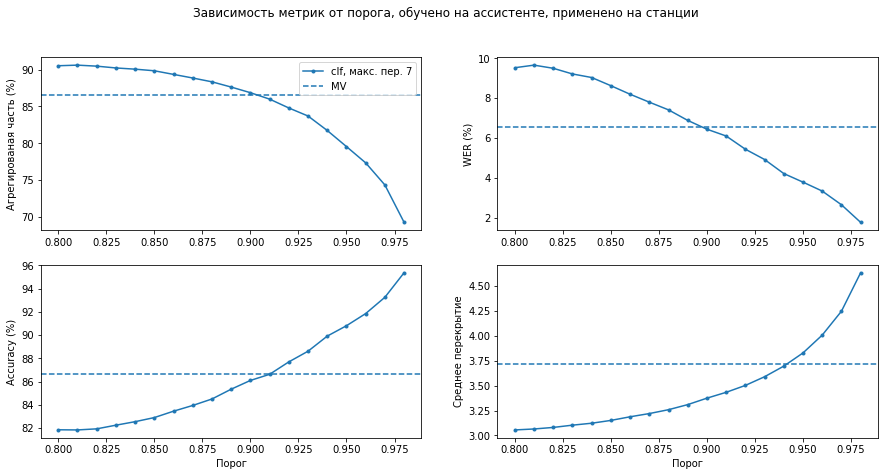

In [39]:
plt.figure(figsize=(15,7))
plt.suptitle('Зависимость метрик от порога, обучено на ассистенте, применено на станции')
plt.subplot(221)
plt.plot(scores_clf_test_q[:, 0], 
         scores_clf_test_q[:, 1] * 100, 
         ".-", 
         label="clf, макс. пер. 7")
plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV")
plt.legend()
plt.ylabel('Агрегированая часть (%)')

plt.subplot(222)
plt.plot(scores_clf_test_q[:, 0], 
         scores_clf_test_q[:, 2] * 100, 
         ".-")
plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--', label="MV")
plt.ylabel('WER (%)')


plt.subplot(223)
plt.plot(scores_clf_test_q[:, 0], 
         scores_clf_test_q[:, 3] * 100, 
         ".-")
plt.axhline(y=prod_agg_metrics[2] * 100, color=u'#1f77b4', linestyle='--', label="MV")
plt.ylabel('Accuracy (%)')

plt.xlabel('Порог')

plt.subplot(224)
plt.plot(scores_clf_test_q[:, 0], 
         scores_clf_test_q[:, 4], 
         ".-")
plt.axhline(y=prod_agg_metrics[3], color=u'#1f77b4', linestyle='--', label="MV")
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')

plt.savefig("assistant_clf_for_quasar.png")
plt.show()

In [41]:
metrics = evaluate_metrics_clf_(valid_rows, 
                                test_features_q_url, 
                                'toloka_assignments_repeat_4_selected_workers_with_pitch', 
                                clf_q, 
                                0.948,
                                min_cost=3,
                                max_cost=7)

Aggregated: 80.0876%
WER: 3.8429%
Accuracy: 90.6977%
Mean overlap: 3.8
